### Goals of this code
1.  Experiment with different datasets on same parameters to find differences and project them
2.  Experiment different parameters and plot as they scale , fine-tune and plot plot plot
3.  Add temporal information and do 2 again

### Next code goals
1.  Try transfer learning of your own by training same network and fine-tuning for different (progressively closer) datasets
2.  CNN-RNN
3.  Add non-NN feature extraction somehow
4.  Plot plot plot


In [1]:
import utilities as ut
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import cv2

### We'll work with three different datasets and compare the results between them
1. The Movie Fights dataset
    A collection
2. RWF-2000 dataset
    A collection


In [2]:
RWF = ut.Preprocess("RWF-2000","RWF-2000 Dataframe")
Movies = ut.Preprocess("Peliculas","Peliculas Dataframe")

### Pros/Cons of each dataset
#### As we can see the RWF-2000 Dataset represents more realistic scenarios, however it's harder to train. 
1. The dataset is very big, 2000 clips and 3000 frames
2. The camera angle is placed up high and at an angle, making scenes of interest appear in all sorts of angles and distances.Also optimal lighting conditions rarely exist.
3. The difference between Fight/Non-Fight scenes is exaggerated in Movies Dataset. In RWF-2000 it's harder even for the human eye to classify individual frames.
##### Also, by noticing both we can see that in some cases its hard to tell if the frame constitutes a fight scene just by that frame alone.
We will need a way to code temporal information.

(240, 320, 3)
(720, 1280, 3)
(576, 720, 3)
(480, 720, 3)


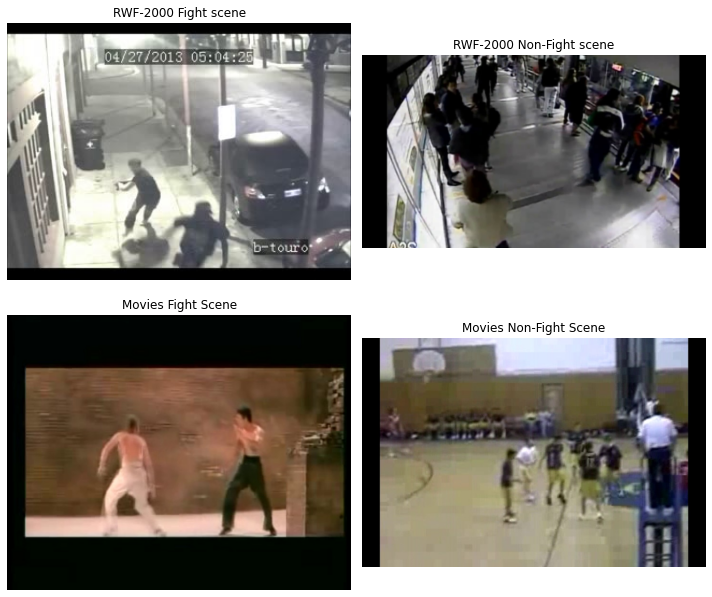

In [3]:
#Get two random images from each dataset
randF1 = RWF.get_random_asset("train","Fight",False)
randNF1 = RWF.get_random_asset("train","NonFight",False)
randF2 = Movies.get_random_asset("train","Fight",False)
randNF2 = Movies.get_random_asset("train","NonFight",False)
compare = [randF1, randNF1, randF2, randNF2]
titles = ["RWF-2000 Fight scene", "RWF-2000 Non-Fight scene", "Movies Fight Scene", "Movies Non-Fight Scene"]
RWF.plot_album((10,10),compare,2,2,titles)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


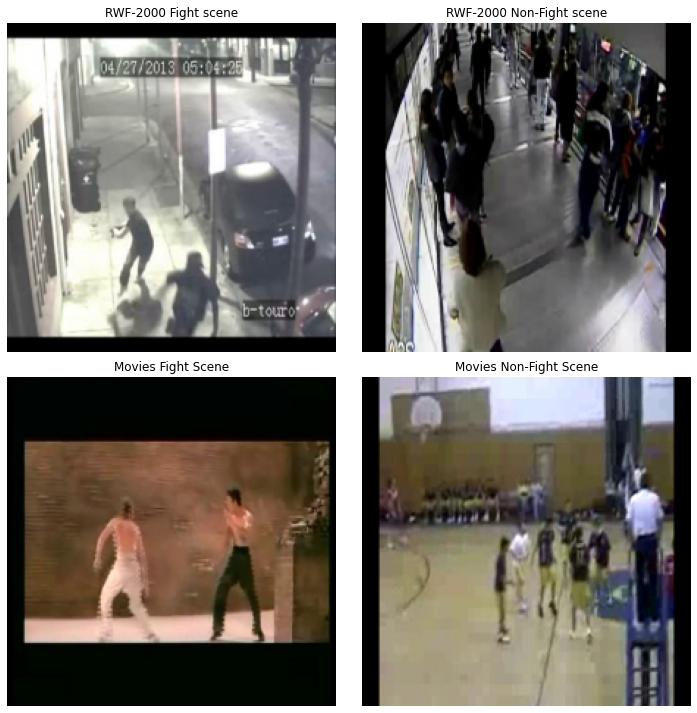

In [4]:
RWF.plot_album((10,10),compare,2,2,titles,(224,224,3))

#### Difference between consecutive frames

(224, 398, 3)
(224, 398, 3)
(224, 398, 3)
(224, 398, 3)


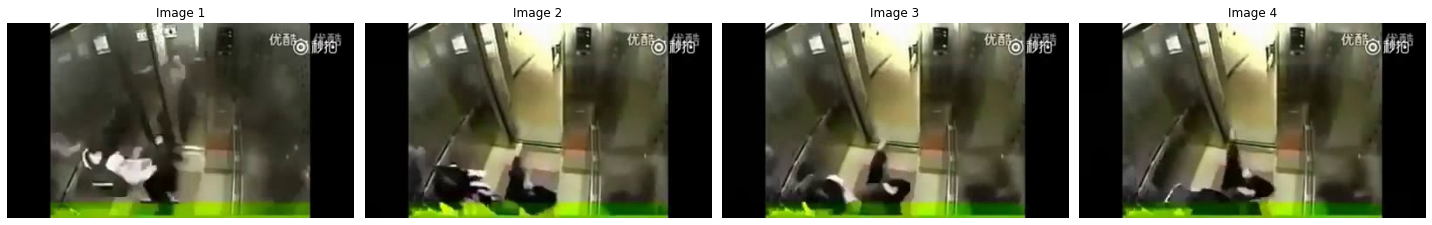

In [9]:
#get 4 consecutive frames and print them
rand1 = RWF.get_random_asset("train","Fight",False)
path, name = os.path.split(rand1)
total = os.listdir(path)
i = total.index(name)
arr = total[i:i+4]
new = [path+'/'+x for x in arr]
titles = ["Image 1","Image 2","Image 3","Image 4"]
RWF.plot_album((20,20),new,1,4,titles)

### The network
For the network's architecture, in the beggining, we'll use a pre-existing model called InceptionNetV3. 
InceptionNetV3 is pre-trained in a variety of images in which we'll strip the output classification and input layers and use transfer learning.

In [10]:
#import necessary tensorflow components
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

### Base model
The base model we will be working with will have an input layer of (224,224,3).
We also have stripped the top 100-class layer to be replaced for our binary classification problem.

In [11]:
IMG_SIZE = 224
base_model = tf.keras.applications.InceptionV3(include_top= False, weights= 'imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

### Show the models architecture

In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### How the input images look

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


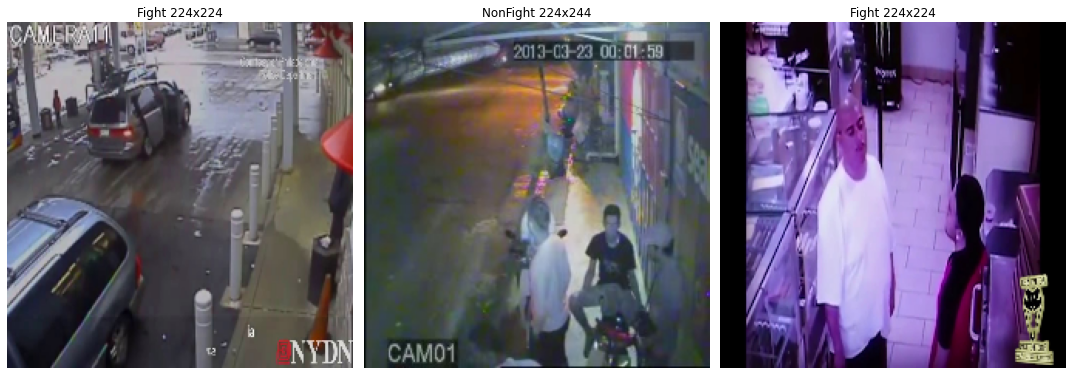

In [20]:
rand1, rand2, rand3 = RWF.get_random_asset("train","Fight",False), RWF.get_random_asset("train","NonFight",False), RWF.get_random_asset("train","Fight",False)
titles = ["Fight 224x224","NonFight 224x244","Fight 224x224"]
RWF.plot_album((15,15),[rand1, rand2, rand3], 1, 3, titles, (IMG_SIZE,IMG_SIZE))

## Output layers
Add pooling layers and binary output using softmax activation

In [14]:
base_model.trainable = False
pool = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation = 'softmax')(pool)

model = Model(inputs = base_model.input, outputs= output)

In [15]:
#We'll use these values in the beggining
LR = 0.0001
BATCH_SIZE = 64
MOMENTUM = 0.9
EPOCHS = 5

## Set callbacks
1. Model Checkpoint
2. Early stoppage
3. Learning Rate Scheduler / ReduceLROnPlateau

## Image data generator
#### RWF-2000

In [22]:
train_dir_RWF = 'RWF-2000 Dataframe/train'
val_dir_RWF = 'RWF-2000 Dataframe/val'
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_RWF,
                                                                            image_size=(IMG_SIZE,IMG_SIZE),
                                                                            label_mode="binary", 
                                                                            batch_size=32) 
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir_RWF,
                                                                           image_size=(IMG_SIZE,IMG_SIZE),
                                                                           label_mode="binary")


Found 79997 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [ ]:
'''
#We wont use ImageDataGenerator as Image dataset works better
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir_RWF = 'RWF-2000 Dataframe/train'
val_dir_RWF = 'RWF-2000 Dataframe/val'

train_data_RWF = train_datagen.flow_from_directory(train_dir_RWF,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)
valid_data_RWF = valid_datagen.flow_from_directory(val_dir_RWF,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
                                               '''

#### Movies Dataset

In [23]:
train_dir_Movies = 'Peliculas Dataframe/train'
val_dir_Movies = 'Peliculas Dataframe/val'
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_Movies,
                                                                            image_size=(IMG_SIZE,IMG_SIZE),
                                                                            label_mode="binary", 
                                                                            batch_size=32) 
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir_Movies,
                                                                           image_size=(IMG_SIZE,IMG_SIZE),
                                                                           label_mode="binary")

Found 4178 files belonging to 2 classes.
Found 447 files belonging to 2 classes.


In [21]:
'''
#We wont use ImageDataGenerator as Image dataset works better
train_datagen2 = ImageDataGenerator(rescale=1./255)
valid_datagen2 = ImageDataGenerator(rescale=1./255)

train_dir_Movies = 'Peliculas Dataframe/train'
val_dir_Movies = 'Peliculas Dataframe/val'

train_data_Movies = train_datagen2.flow_from_directory(train_dir_Movies,
                                               batch_size=BATCH_SIZE, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)
valid_data_Movies = valid_datagen2.flow_from_directory(val_dir_Movies,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

'''

Found 4178 images belonging to 2 classes.
Found 447 images belonging to 2 classes.


In [18]:
#model.summary()

In [19]:
#create video player
#research callbacks
#find optimal learning rate etc
#plot